# Project : Generating faces to remove mask on photos

In [1]:
! pip install opencv-python pyunpack scikit-image pillow==5.3.0
%reload_ext autoreload
%autoreload

     |████████████████████████████████| 3.6 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 13.1 MB 28.5 MB/s eta 0:00:01
     |████████████████████████████████| 35.8 MB 34.1 MB/s eta 0:00:01     |█████████████████████▋          | 24.1 MB 34.1 MB/s eta 0:00:01     |████████████████████████████    | 31.2 MB 34.1 MB/s eta 0:00:01
     |████████████████████████████████| 13.0 MB 24.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 10.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 33.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 19.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 32.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 23.7 MB/s eta 0:00:01     |██████████▋                     | 1.1 MB 23.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 22.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 22.3 MB/s eta 0:00:01
     |███████████████████████████

## I - Dataset

## II - GAN Model

In [2]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F

from pyunpack import Archive
from tensorflow import keras 
from keras.utils.data_utils import Sequence

from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Flatten, Reshape, Dense, add
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
import random, math



Unable to revert mtime: /Library/Fonts
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [3]:
masks = [f"./training_set_small/001_Combined_masked/{str(i).rjust(5,'0')}_N95.png" for i in range(2000,4000)]
nomasks = [f"./training_set_small/001_Combined_original/{str(i).rjust(5,'0')}.png" for i in range(2000,4000)]

In [4]:
print(len(nomasks))
print(len(masks))

2000
2000


In [5]:
class Daugmentation:
    def flip(img, t):
        if t[0]==0:
            return img
        else:
            return cv2.flip(img, t[1])

    def zoom(img, t):
        if t[2]==0:
            return img
        else:
            h, w = img.shape[:2]
            nh, nw =  int(t[3]*h), int(t[3]*w)
            dh, dw = h-nh, w-nw
            zimg = img[dh//2:nh+dh//2, dw//2:nw+dw//2]
            zimg = cv2.resize(zimg, (w,h))
            return zimg


    def get_ts(batch_size):
        return [[random.choice([0,1]),random.choice([-1,0,1]), random.randint(0,2),random.uniform(0.4,0.9)] for i in range(batch_size)]

    def aug(img,t):
        img = Daugmentation.flip(img,t)
        # img = Daugmentation.zoom(img, t)
        return img


class maSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, Daugmentation):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = Daugmentation

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        ts = self.augment.get_ts(len(batch_x))
        return np.array([self.augment.aug(x,t) for x,t in zip(batch_x,ts)]),np.array([self.augment.aug(y,t) for y,t in zip(batch_y,ts)]) 

In [8]:

from tqdm import tqdm
X = []
Y = []
test = []
for i in tqdm(zip(masks, nomasks)):
    # print(i[0])
    try:
        img = load_img(i[0], target_size=(128,128))
        X.append(img_to_array(img)/250.)
        img = load_img(i[1], target_size=(128,128))
        Y.append(img_to_array(img)/250.)

    except Exception as e: 
        # print(e)
        continue


X = np.array(X)
Y = np.array(Y)
print(len(X),len(Y))
np.random.seed(777)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.1)
# x_train = torch.tensor(x_train).view(-1,3,128,128)
# y_train = torch.tensor(y_train).view(-1,3,128,128)
# x_test = torch.tensor(x_test).view(-1,3,128,128) 
# y_test = torch.tensor(y_test).view(-1,3,128,128)
# print(x_train.size(),y_train.size(), x_test.size(), y_test.size())
x_train.shape,y_train.shape, x_test.shape, y_test.shape


2000it [00:08, 238.27it/s]


1485 1485


((1336, 128, 128, 3),
 (1336, 128, 128, 3),
 (149, 128, 128, 3),
 (149, 128, 128, 3))

In [9]:
print(torch.tensor(x_train).view(-1,3,128,128).size())

torch.Size([1336, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

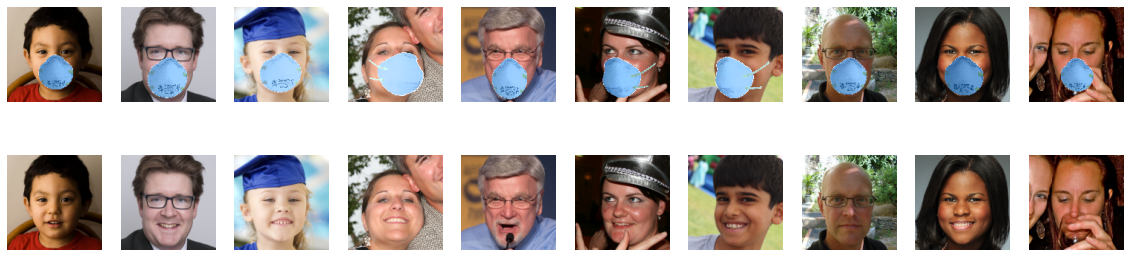

In [10]:
plt.figure(figsize=(20,5))
masks = x_test[:10]
nomasks = y_test[:10]
for i, (x,y) in enumerate(zip(masks[:10],nomasks[:10])):
    plt.subplot(2,10,i+1)
    plt.imshow(x)
    plt.axis("OFF")
    
    plt.subplot(2,10,i+11)
    plt.imshow(y)
    plt.axis("OFF")
plt.show()

In [11]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # First
        
        self.c1_1 = nn.Conv2d(3, 32, kernel_size = 3, padding = "same")
        self.c1_2 = nn.Conv2d(32, 32, kernel_size = 3, padding = "same")
        self.m1 = nn.MaxPool2d(2,2)

        self.c2_1 = nn.Conv2d(32, 64, 3, padding = "same")
        self.c2_2 = nn.Conv2d(64, 64, 3, padding = "same")
        self.m2 = nn.MaxPool2d(2,2)

        self.c3_1 = nn.Conv2d(64, 128, 3, padding = "same")
        self.c3_2 = nn.Conv2d(128, 128, 3, padding = "same")
        self.m3 = nn.MaxPool2d(2,2)

        self.c4_1 = nn.Conv2d(128, 256, 3, padding = "same")
        self.c4_2 = nn.Conv2d(256, 256, 3, padding = "same")


        self.u1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1)
        self.c5_1 = nn.ConvTranspose2d(128,128, 3, padding = 1)
        self.c5_2 = nn.ConvTranspose2d(128,128, 3, padding = 1)

        self.u2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.c6_1 = nn.ConvTranspose2d(64, 64, 3, padding = 1)
        self.c6_2 = nn.ConvTranspose2d(64, 64, 3, padding = 1)

        self.u3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1)
        self.c7_1 = nn.ConvTranspose2d(32, 32, 3, padding = 1)
        self.c7_2 = nn.ConvTranspose2d(32, 32, 3, padding = 1)

        self.c8 = nn.Conv2d(32,3,3,padding = 1)
        

    def forward(self, x):
        c1 = self.c1_1(x)
        c1 = F.relu(c1)
        c1 = self.c1_2(c1)
        c1 = F.relu(c1)
        x = self.m1(c1)

        c2 = self.c2_1(x)
        c2 = F.relu(c2)
        c2 = self.c2_2(c2)
        c2 = F.relu(c2)
        x = self.m2(c2)

        c3 = self.c3_1(x)
        c3 = F.relu(c3)
        c3 = self.c3_2(c3)
        c3 = F.relu(c3)
        x = self.m3(c3)

        c4 = self.c4_1(x)
        c4 = F.relu(c4)
        c4 = self.c4_2(c4)
        c4 = F.relu(c4)

        u1 = self.u1(c4)
        u1 = F.pad(u1, (0, 1, 0, 1))
        c5 = self.c5_1(u1)
        c5 = F.relu(c5)
        c5 = self.c5_2(c5)
        c5 = F.relu(c5)

        a1 = torch.add(c5,c3)
        u2 = self.u2(a1)
        u2 = F.pad(u2, (0, 1, 0, 1))
        c6 = self.c6_1(u2)
        c6 = F.relu(c6)
        c6 = self.c6_2(c6)
        c6 = F.relu(c6)

        a2 = torch.add(c6,c2)
        u3 = self.u3(a2)
        u3 = F.pad(u3, (0, 1, 0, 1))
        c7 = self.c7_1(u3)
        c7 = F.relu(c7)
        c7 = self.c7_2(c7)
        c7 = F.relu(c7)

        a3 = torch.add(c7,c1)
        c8 = self.c8(a3)
        output = F.sigmoid(c8)

        return output



In [12]:
import torch
from torch import nn
import random

import torchvision
from torch.utils.data import Dataset, DataLoader

def get_device():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    return device

device = get_device()
device

device(type='cpu')

In [13]:
from torchsummary import summary
net = Generator()
print(net)
summary(net, (3, 128, 128))

ModuleNotFoundError: No module named 'torchsummary'

In [45]:
model = Generator().to(device)
import pytorch_ssim

# # Loss functtion
# def ssim_loss(y_true, y_pred):
#   return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
# def SSIM_CRITERION(predicted, target):
#     # print(predicted.shape, target.shape)
#     # return ssim(predicted, target, multichannel=True)
#     return tf.reduce_mean(tf.image.ssim(predicted, target, 2.0))
    
    

# model = torch.load("./unmask_encoder.pt").to(device)
model.eval()
criterion = pytorch_ssim.SSIM(window_size = 11)

lr = 0.001
optimizer= torch.optim.Adam(model.parameters(), lr=lr)
net = Generator()
batch_size = 16
train_generator = maSequence(x_train, y_train, batch_size, Daugmentation)
test_generator = maSequence(x_test, y_test, batch_size,Daugmentation)

In [46]:
def eval_function():
    
    with torch.no_grad():
            for batch_x, batch_y in test_generator:
                input_image = torch.from_numpy(batch_x).to(torch.float32).to(device)
                target_image = torch.from_numpy(batch_y).to(torch.float32).to(device)
                outputs = model(input_image.view(-1,3,128,128))
                
    
    loss_eval = criterion(outputs, target_image.view(-1,3,128,128))
    return loss_eval.item()


In [47]:
len(train_generator)

84

In [48]:
loss_evolution = []
epochs = []
validate_loss_evolution = []
for epoch in range(1,300):
 
    for i, (batch_x, batch_y) in enumerate(train_generator):
        
        input_image = torch.from_numpy(batch_x).to(torch.float32).to(device)
        target_image = torch.from_numpy(batch_y).to(torch.float32).to(device)
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        outputs = model(input_image.view(-1,3,128,128))
        loss = criterion(outputs, target_image.view(-1,3,128,128))
        loss.backward()
        optimizer.step()
           
    
    if epoch%5 == 0:
        validate_loss = eval_function()
        print("loss = ", loss.item(), " ", "validate_loss = ", validate_loss)
        loss_evolution.append(loss.item())
        validate_loss_evolution.append(validate_loss)
        epochs.append(epoch)
        print(' ')

In [ ]:
torch.save(model, f"./unmask_encoder.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

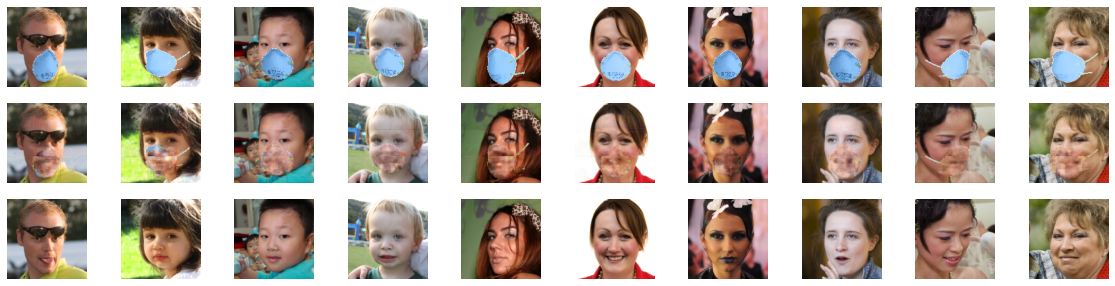

In [ ]:
plt.figure(figsize=(20,5))
masks = x_test[:10]
inputs = torch.tensor(masks).view(-1,3,128,128)
device = torch.device('cpu')
inputs = torch.Tensor.cpu(inputs)
model = model.to(device)
nomask_preds = model(inputs).view(-1,128,128,3).detach().numpy()
nomask_actuals = y_test[:10]
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(masks[i])
    plt.axis("OFF")
    
    plt.subplot(3,10,i+11)
    plt.imshow(nomask_preds[i])
    plt.axis("OFF")
    
    plt.subplot(3,10,i+21)
    plt.imshow(nomask_actuals[i])
    plt.axis("OFF")
plt.show()

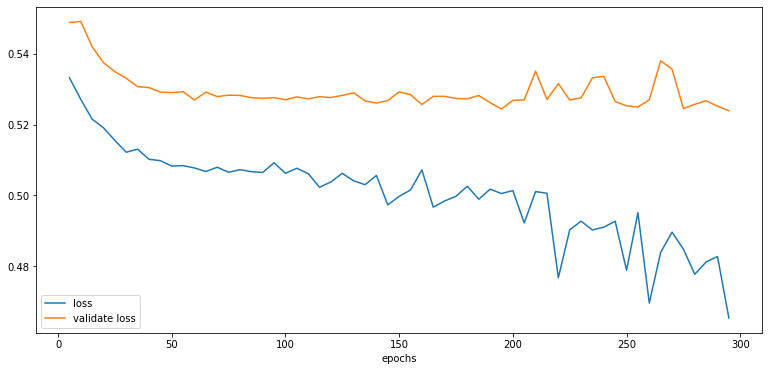

In [23]:
plt.plot(epochs, loss_evolution, label = "loss")
plt.plot(epochs, validate_loss_evolution, label = "validate loss")
plt.legend(loc="lower left")
plt.xlabel("epochs")
plt.show()